# Step 0: Install packages

In [ ]:
import os
import sys
import lasio
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from numpy import Inf, sqrt
from tqdm.auto import tqdm

import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split

import torch

# sys.path.append('./src')
from src import *
from train import main

from warnings import filterwarnings
filterwarnings('ignore')

%matplotlib inline
%config BackendInline.figure_format = 'retina'
pd.options.display.max_columns = 23

# Step 1: Data Loading

# Step 1.1 Plot Well location

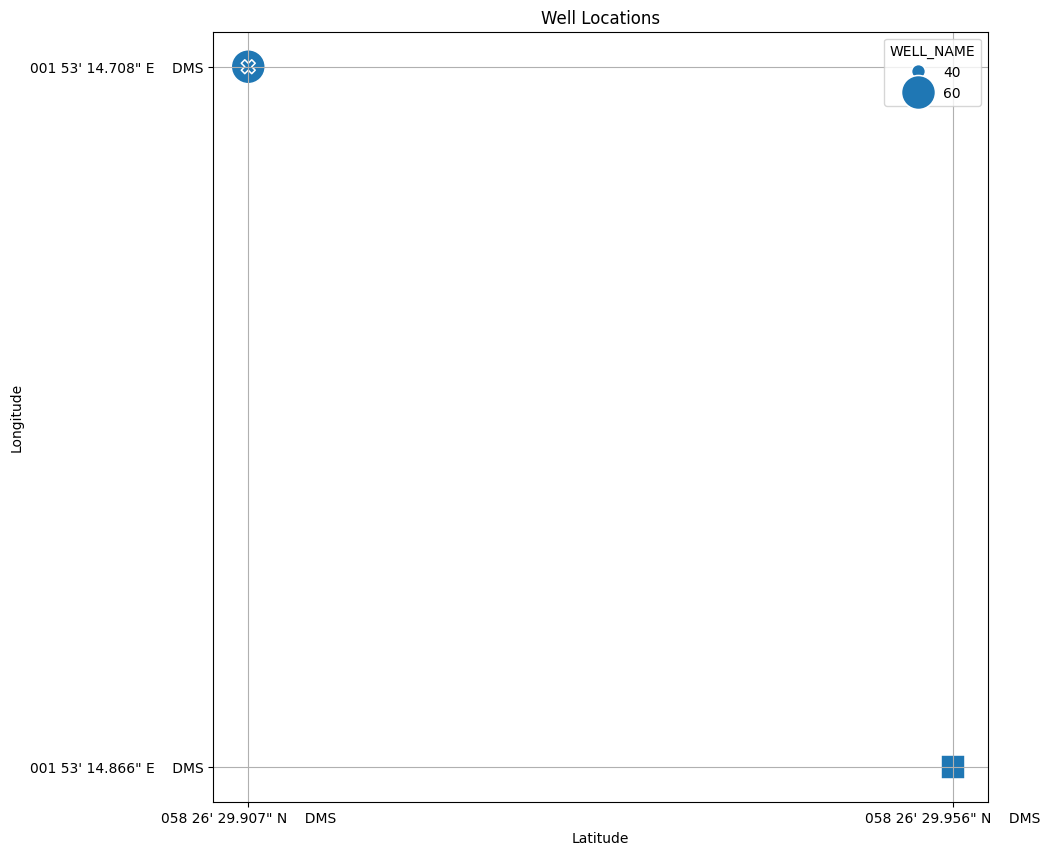

In [ ]:
def plot_well_loc(files):

    '''
    returns the location of the well if available in the original LAS file
    args::
        files: LAS file_path takes in the original LAS file as argument

    '''
    well_name = list()
    latitude = list()
    longitude = list()
    max_depth = list()


    for file in files:
        well_name.append(f'{str(file[2:-4])}')
        well_data = lasio.read(os.path.join("data/", file))
        longitude.append(well_data.well.LONG.value)
        latitude.append(well_data.well.LATI.value)
        max_depth.append(well_data.well.STOP.value)

    well_df = pd.DataFrame({'WELL_NAME':well_name,'LAT':latitude,'LONG':longitude,'DEPTH':max_depth})

    plt.figure(figsize=(10,10))
    plt.title('Well Locations')
    sns.scatterplot(x ='LAT', y = 'LONG', data = well_df,
                    size= [60, 40, 60], sizes = (100,600), style='WELL_NAME')
    plt.grid()
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')

files = ['15_9-F-1A.LAS', '15_9-F-1B.LAS', '15_9-F-11A.LAS',]

plot_well_loc(files)

In [ ]:
# get all paths and alphabetically ordered
# paths = sorted(glob.glob(os.path.join("./", "*.LAS")))
paths = ['15_9-F-11A.LAS', '15_9-F-11T2.LAS', '15_9-F-1A.LAS', '15_9-F-1B.LAS',
         '15_9-F-4.LAS']

well_df = [0] * 5

for i in range(len(paths)):
    # read with lasio and convert to dataframe
    df = (lasio.read(os.path.join("data/", paths[i]))).df()

    well_df[i] = df.reset_index()

well1, well2, well3, well4, well5 = well_df

In [ ]:
well1 = process_train(well1, col, name='15_9-F-11A')
well2 = process_test(well2, col, name='15_9-F-11T2') #validation
well3 = process_train(well3, col, name='15_9-F-1A')
well4 = process_train(well4, col, name='15_9-F-1B')
well5 = process_test(well5, col, name='15_9-F-4') #validation


In [ ]:
train = pd.concat((well1, well3, well4), axis='index').reset_index(drop=True)
test = pd.concat((well2, well5), axis='index').reset_index(drop=True)

#Step 2: Visualizations

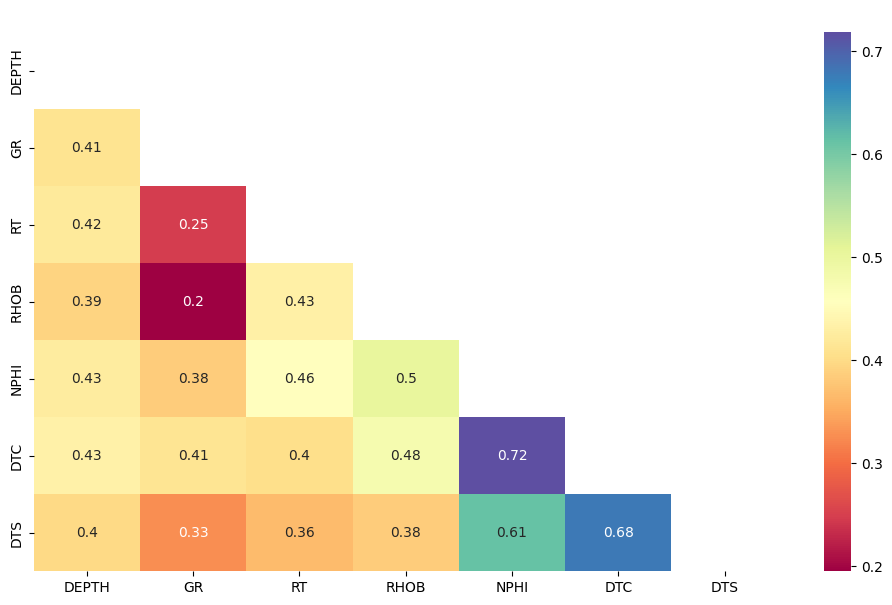

In [ ]:
corr = Correlation(train.select_dtypes('float64'))
v = corr.corr(method='chatterjee')
corr.plot_heatmap(' ', cmap='Spectral')

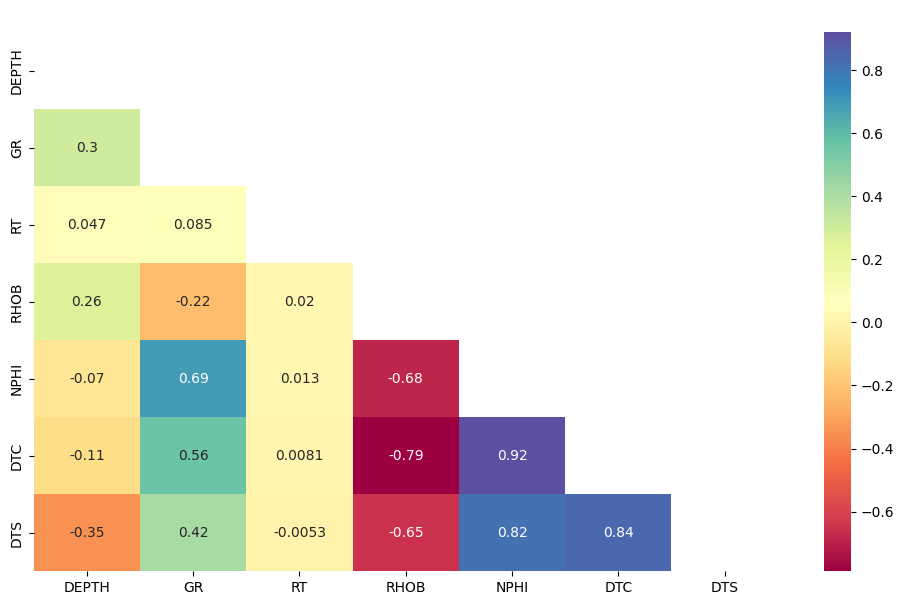

In [ ]:
corr = Correlation(train.select_dtypes('float64'))
v = corr.corr(method='pearsonr')
corr.plot_heatmap(' ', cmap='Spectral')

# Step 4: Data Tranformation

In [ ]:
#combine train and test for easy transformation
wells = pd.concat((train, test), axis='index').reset_index(drop=True)

wells['GR'] = np.where(wells['GR'] <= 200., wells['GR'], 200.)
wells['RT'] = np.where(wells['RT'] <= 2000., wells['RT'], 2000.)

wells['RT'] = np.log10(wells['RT'])

In [ ]:
#split back into train and test
train_ = wells[:train.shape[0]]
test_ = wells[train.shape[0]:]

features = ['GR', 'RT', 'RHOB', 'NPHI'] # only feature column names
target = ['DTC', 'DTS'] # only target column names
feature_target = ['GR', 'RT', 'RHOB', 'NPHI', 'DEPTH', 'WELL', 'DTC', 'DTS']

#scaler
scaler = PowerTransformer(method='yeo-johnson')
ct = ColumnTransformer([('transform', scaler, features)], remainder='passthrough').fit(train_)

#transform train and test set
t_new_wells = ct.transform(train_)
tt_new_wells = ct.transform(test_)

t_wells_norm = pd.DataFrame(t_new_wells, columns=feature_target)
tt_wells_norm = pd.DataFrame(tt_new_wells, columns=feature_target)


#convert into correct type
x1 = t_wells_norm[features].astype(float)
y1 = t_wells_norm['WELL'].astype(str)
z1 = t_wells_norm['DEPTH'].astype(float)

x2 = tt_wells_norm[features].astype(float)
y2 = tt_wells_norm['WELL'].astype(str)
z2 = tt_wells_norm['DEPTH'].astype(float)

#joining data together
t_wells_norm = pd.concat([z1, y1, x1], axis=1)
t_wells_norm['DTC'] = train_.DTC
t_wells_norm['DTS'] = train_.DTS

tt_wells_norm = pd.concat([z2, y2, x2], axis=1)
tt_wells_norm['DTC'] = test_.DTC
tt_wells_norm['DTS'] = test_.DTS

# Step 5: Data split

In [ ]:

#split into train, val and test set
train_x_ = t_wells_norm[t_wells_norm.columns[2:6]]
train_y_ = t_wells_norm[['DTC', 'DTS']]


test_x = tt_wells_norm[tt_wells_norm.columns[2:6]]
test_y = tt_wells_norm[['DTC', 'DTS']]

# #train and validation split
train_x, val_x, train_y, val_y = train_test_split(train_x_, train_y_, shuffle=True,
                                                  test_size=0.3, random_state=2024)


In [ ]:
#propocessed blind test wells
test_well2_x = test_x[:well2.shape[0]]
test_well2_y = test_y[:well2.shape[0]]

test_well5_x = test_x[well2.shape[0]:]
test_well5_y = test_y[well2.shape[0]:]

In [ ]:
#propocessed training wells
train_well1_x = train_x_[:well1.shape[0]]
train_well1_y = train_y_[:well1.shape[0]]

train_well3_x = train_x_[well1.shape[0]:(well1.shape[0]+well3.shape[0])]
train_well3_y = train_y_[well1.shape[0]:(well1.shape[0]+well3.shape[0])]

train_well4_x = train_x_[(well1.shape[0]+well3.shape[0]):]
train_well4_y = train_y_[(well1.shape[0]+well3.shape[0]):]

# Step 7: Model training

In [ ]:
EPOCHS = 300
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 256

In [ ]:
trainloader = dloader(train_x, train_y, bs=256)
valloader = dloader(val_x, val_y, bs=256)

In [ ]:
random_seed = 2024
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

model = Log1DNetv3(batch_size=256)

print(model.to(device))

train_dtc_loss, train_dtc_score, train_dts_loss, train_dts_score,\
    val_dtc_loss, val_dtc_score, val_dts_loss, val_dts_score = main(model, trainloader,
                                                                    valloader, epochs=EPOCHS)

Log1DNetv3(
  (conv1): Sequential(
    (0): Conv1d(4, 256, kernel_size=(1,), stride=(1,))
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): AvgPool1d(kernel_size=(1,), stride=(1,), padding=(0,))
  )
  (conv2): Sequential(
    (0): Conv1d(256, 512, kernel_size=(1,), stride=(1,))
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): AvgPool1d(kernel_size=(1,), stride=(1,), padding=(0,))
  )
  (conv3): Sequential(
    (0): Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (conv4): Sequential(
    (0): Conv1d(1024, 256, kernel_size=(1,), stride=(1,))
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (

  0%|          | 0/300 [00:00<?, ?it/s]

Model Saved
Epoch 1 Train: DTC Loss=43.6431 | DTC Score=-23.8882 | DTS Loss=105.5390 | DTS Score=-13.5853
Epoch 1 Val: DTC Loss=8.6445 | DTC Score=0.5404 | DTS Loss=29.2960 | DTS Score=0.2816

Model Saved
Epoch 2 Train: DTC Loss=6.8362 | DTC Score=0.6896 | DTS Loss=18.7275 | DTS Score=0.6408
Epoch 2 Val: DTC Loss=5.4766 | DTC Score=0.8324 | DTS Loss=17.8802 | DTS Score=0.7260

Model Saved
Epoch 3 Train: DTC Loss=5.7546 | DTC Score=0.7996 | DTS Loss=16.6806 | DTS Score=0.7652
Epoch 3 Val: DTC Loss=5.5036 | DTC Score=0.8164 | DTS Loss=16.3743 | DTS Score=0.7718

Epoch 4 Train: DTC Loss=5.2381 | DTC Score=0.8319 | DTS Loss=15.9193 | DTS Score=0.7822
Epoch 4 Val: DTC Loss=5.4414 | DTC Score=0.8020 | DTS Loss=16.5932 | DTS Score=0.7690

Model Saved
Epoch 5 Train: DTC Loss=4.5933 | DTC Score=0.8707 | DTS Loss=15.5275 | DTS Score=0.7910
Epoch 5 Val: DTC Loss=4.8797 | DTC Score=0.8591 | DTS Loss=15.8516 | DTS Score=0.7926

Model Saved
Epoch 6 Train: DTC Loss=4.5155 | DTC Score=0.8643 | DTS Los

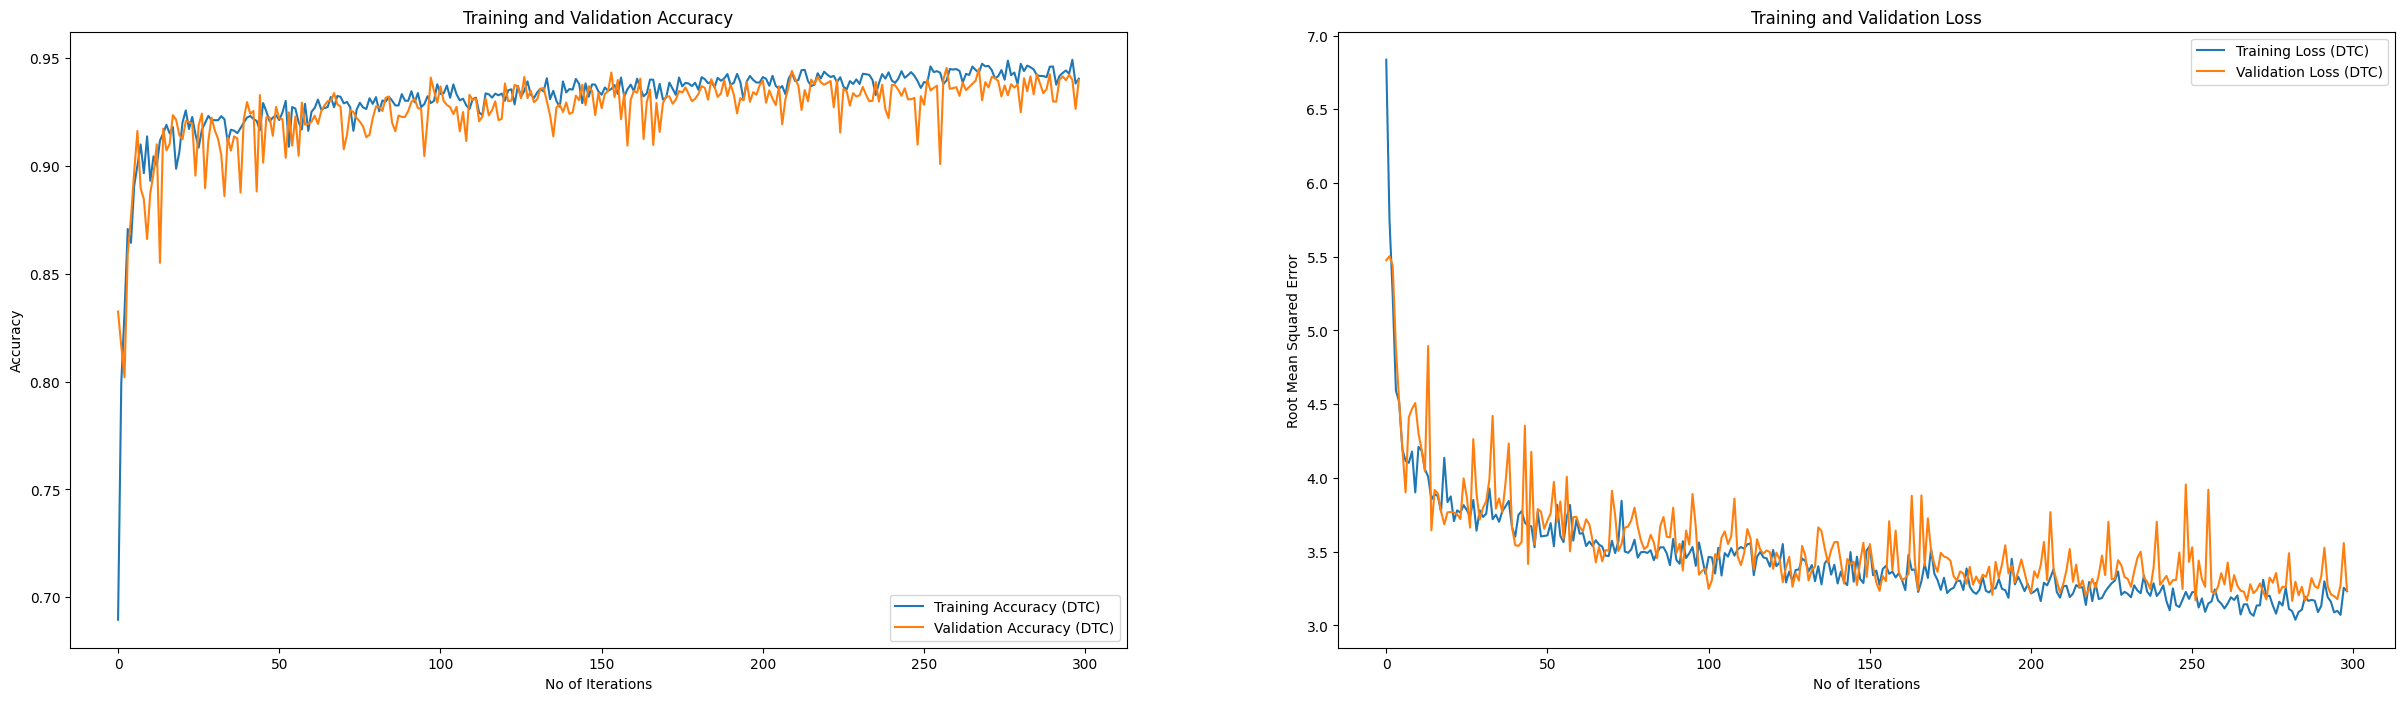

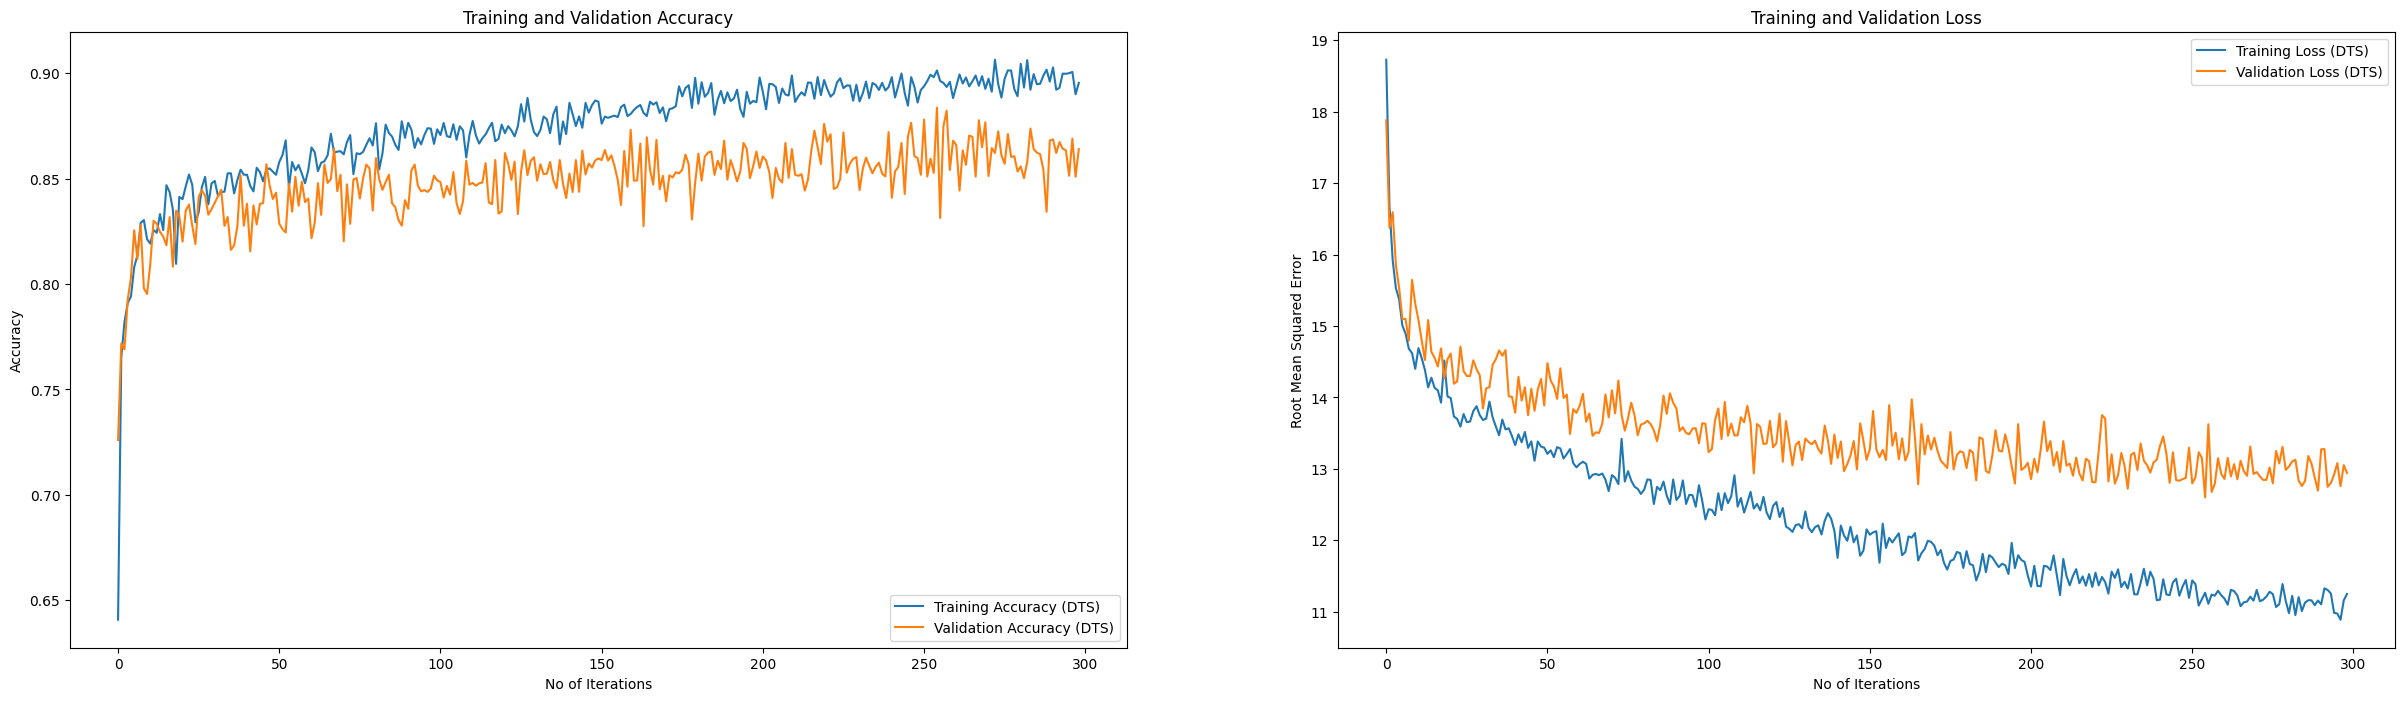

In [ ]:
performance2(
        train_dtc_loss[1:], train_dtc_score[1:], train_dts_score[1:],
        train_dts_loss[1:], val_dtc_score[1:], val_dtc_loss[1:],
        val_dts_score[1:], val_dts_loss[1:]
        )

# Step 8: Inference

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = Log1DNetv3().to(device)
model.load_state_dict(torch.load('model/Log1DNet.pt'))

def predict_logs(x, y, original_df):

    inputs = torch.from_numpy(x.values).to(device).float()
    outputs = torch.from_numpy(y.values).to(device).float()

    dtcs = []; dtss = []
    model.eval()
    for i in range(inputs.shape[0]):
        with torch.inference_mode():
            pred = model(inputs[i].unsqueeze(0).repeat(256, 1, 1))
            dtc = pred[0][0]; dts = pred[0][1]
            dtcs.append(dtc.cpu().numpy()); dtss.append(dts.cpu().numpy())

    df = original_df.copy()
    df['Predicted DTC'] = np.array(dtcs).astype(float)
    df['Predicted DTS'] = np.array(dtss).astype(float)

    return df

The R2 score for Well DTC: 0.9268148884787886
The RMSE for Well DTC: 3.610908825028247
--------------------------------------------------
The R2 score for Well DTS: 0.7779579112563936
The RMSE for Well DTS: 16.230100561974773
--------------------------------------------------


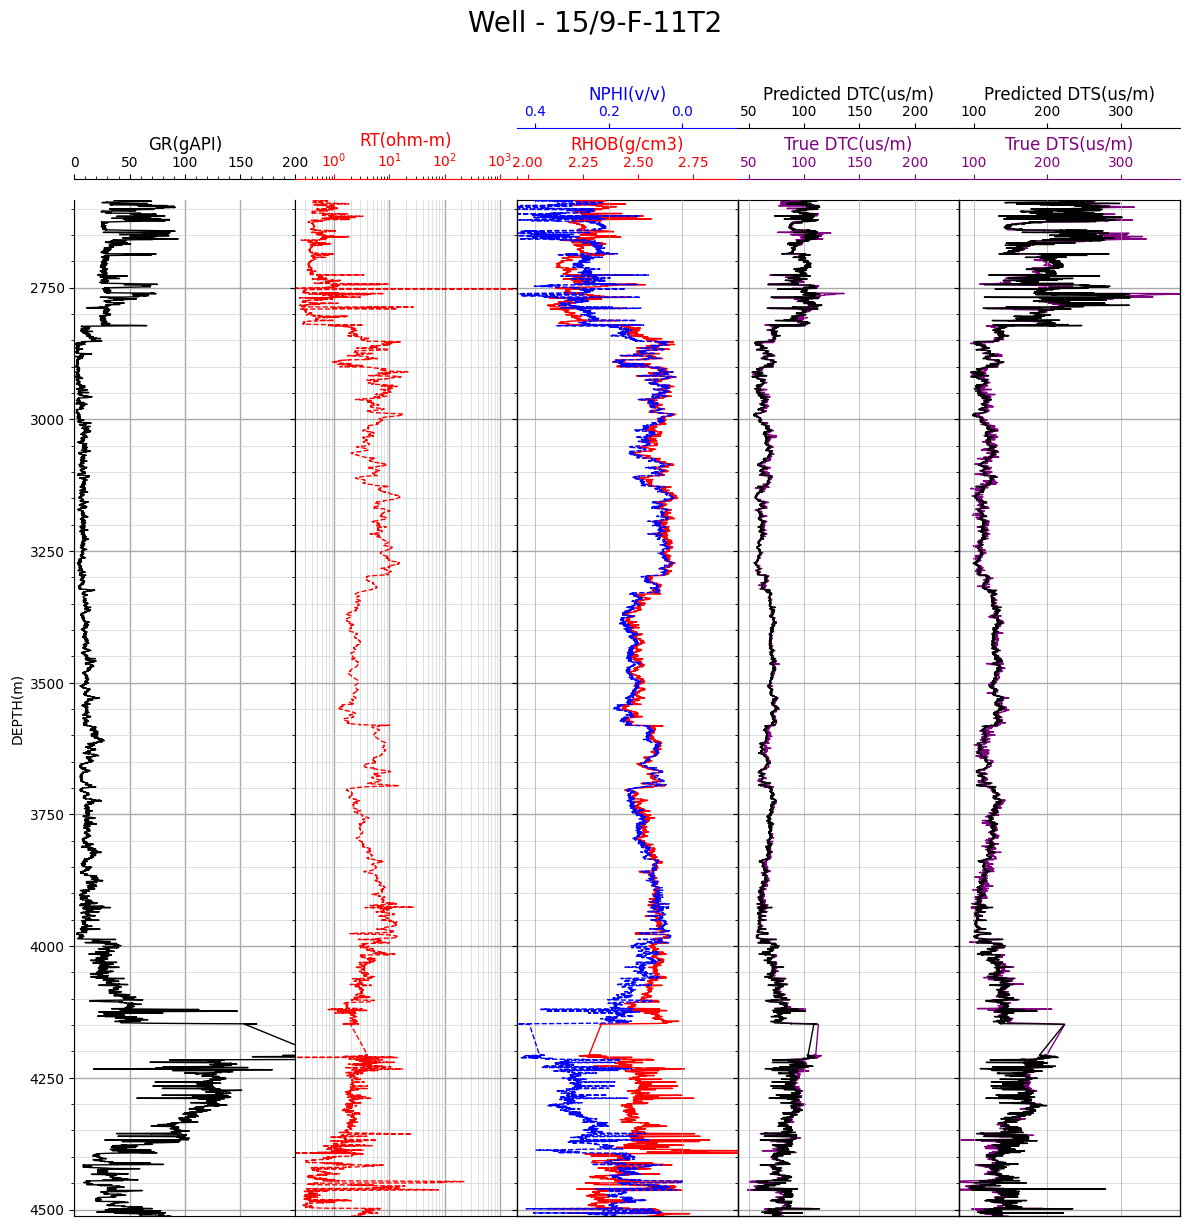

In [ ]:
#blind well 2

well2_new = predict_logs(test_well2_x, test_well2_y, well2)

metrics(pred=well2_new['Predicted DTC'], gt=well2_new['DTC'], name='DTC')
metrics(pred=well2_new['Predicted DTS'], gt=well2_new['DTS'], name='DTS')

make_log_plot(well2_new, 'GR', 'RT', 'RHOB','NPHI',  'DTC',
              'Predicted DTC', 'DTS', 'Predicted DTS', '15/9-F-11T2')

The R2 score for Well DTC: 0.8406554078185321
The RMSE for Well DTC: 4.274898986218311
--------------------------------------------------
The R2 score for Well DTS: 0.535511382512426
The RMSE for Well DTS: 16.47142624766885
--------------------------------------------------


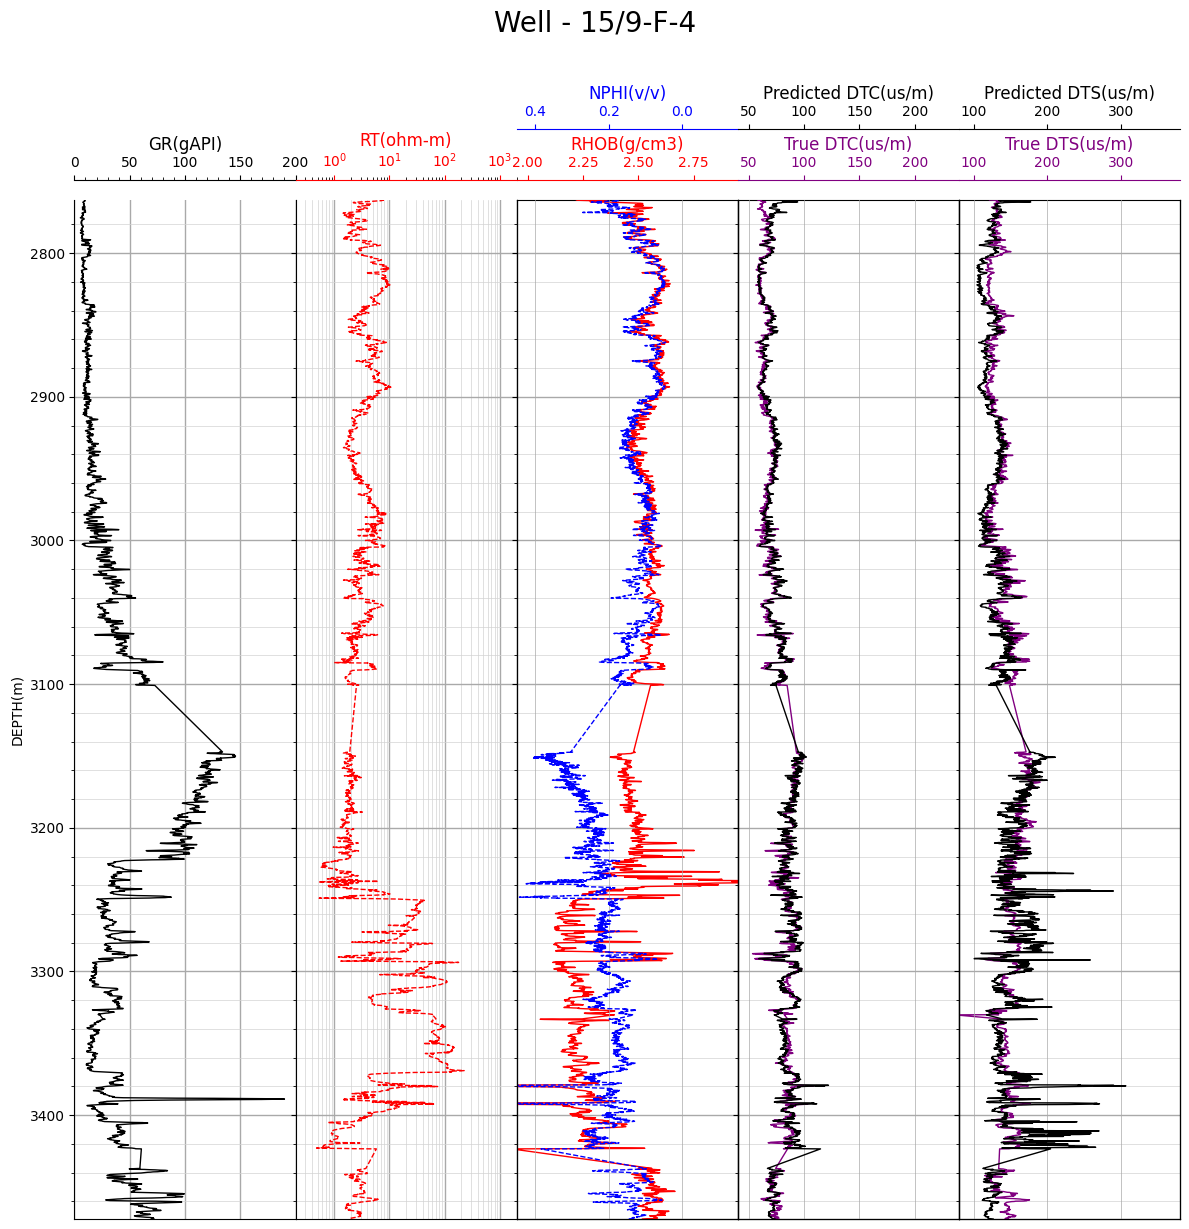

In [ ]:
# well 5
well5_new = predict_logs(test_well5_x, test_well5_y, well5)
metrics(pred=well5_new['Predicted DTC'], gt=well5_new['DTC'], name='DTC')
metrics(pred=well5_new['Predicted DTS'], gt=well5_new['DTS'], name='DTS')

make_log_plot(well5_new, 'GR', 'RT', 'RHOB', 'NPHI',
              'DTC', 'Predicted DTC', 'DTS', 'Predicted DTS', '15/9-F-4')

The R2 score for Well DTC: 0.9521794427691751
The RMSE for Well DTC: 3.2152027842483415
--------------------------------------------------
The R2 score for Well DTS: 0.9108259736024024
The RMSE for Well DTS: 12.67991072346243
--------------------------------------------------


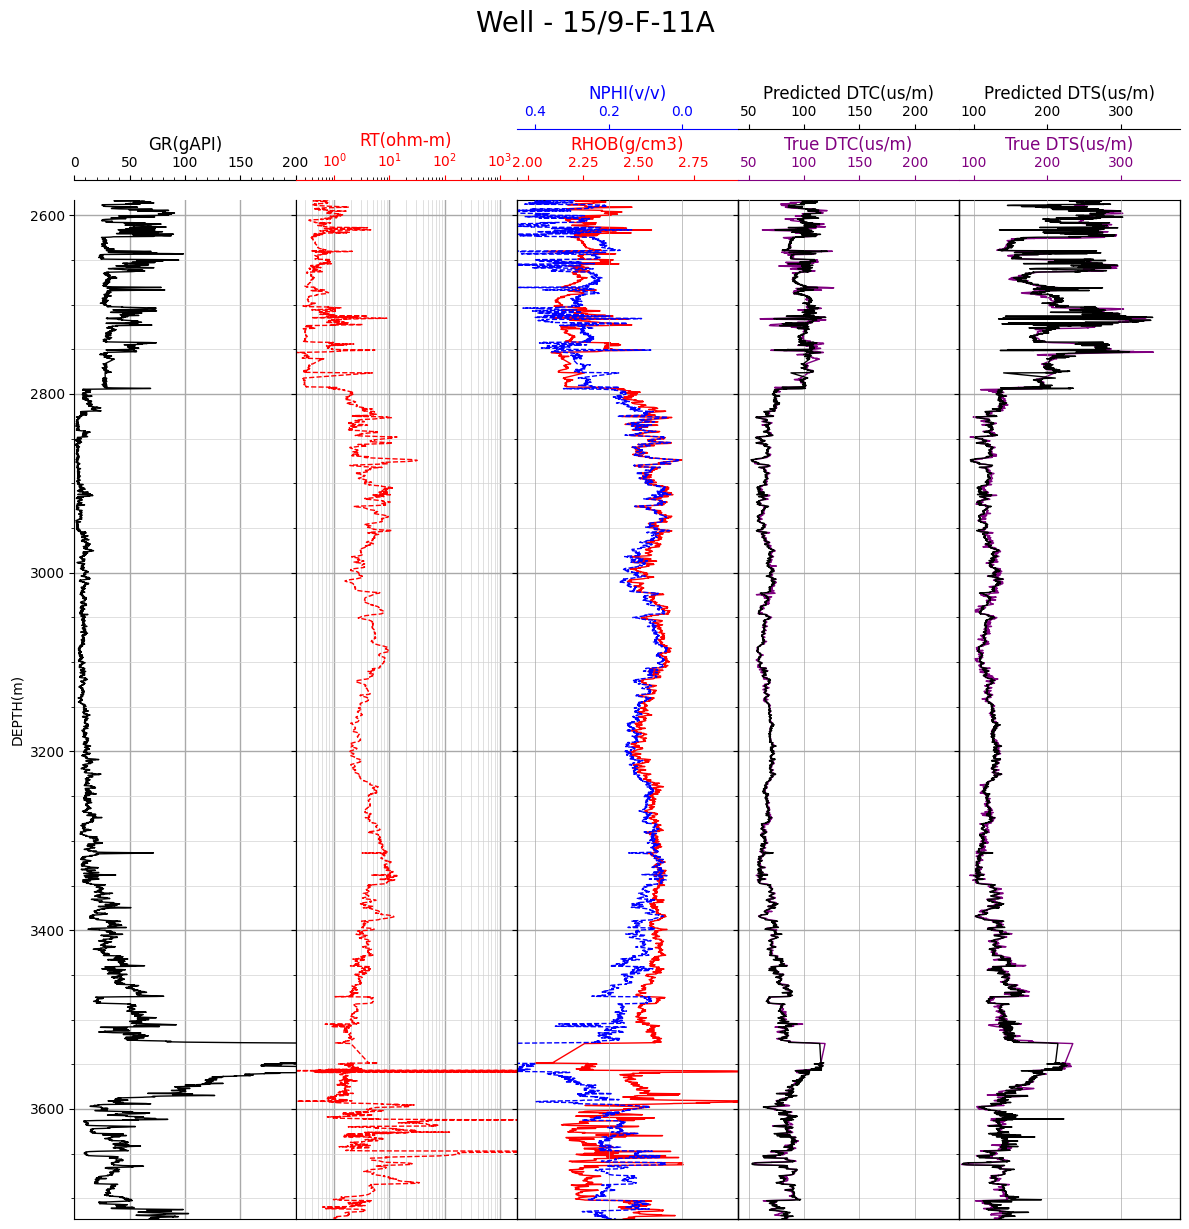

In [ ]:
#well1
well1_new = predict_logs(train_well1_x, train_well1_y, well1)
metrics(pred=well1_new['Predicted DTC'], gt=well1_new['DTC'], name='DTC')
metrics(pred=well1_new['Predicted DTS'], gt=well1_new['DTS'], name='DTS')

make_log_plot(well1_new, 'GR', 'RT', 'RHOB',
              'NPHI', 'DTC', 'Predicted DTC', 'DTS', 'Predicted DTS', '15/9-F-11A')

The R2 score for Well DTC: 0.955069004006814
The RMSE for Well DTC: 2.8178621830912998
--------------------------------------------------
The R2 score for Well DTS: 0.8773487854132512
The RMSE for Well DTS: 10.145254483654917
--------------------------------------------------


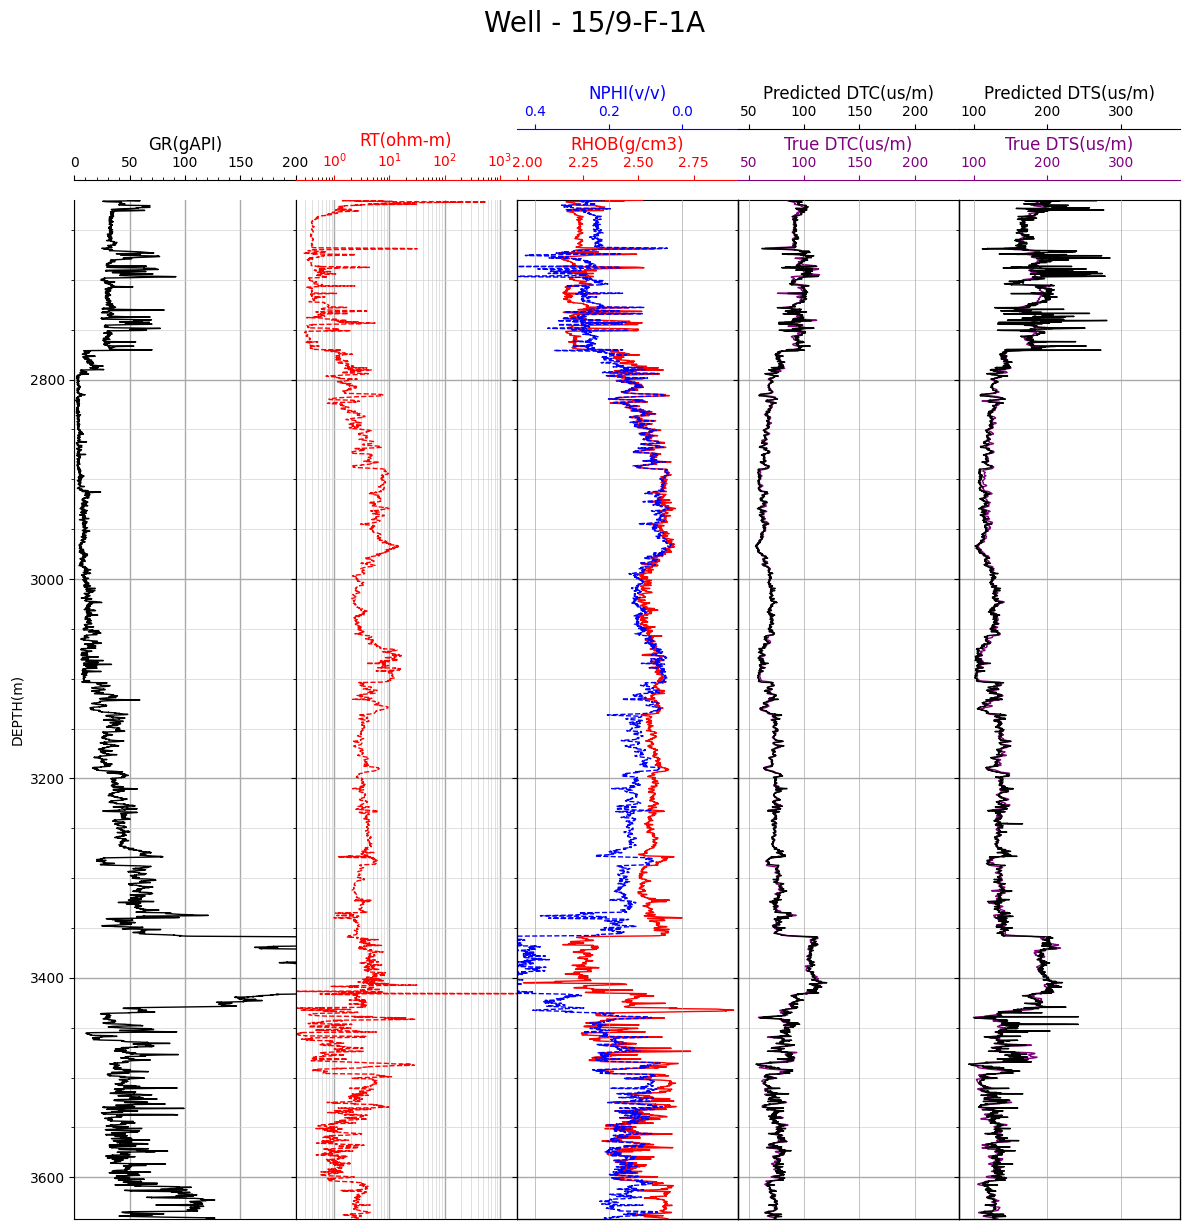

In [ ]:
#well3
well3_new = predict_logs(train_well3_x, train_well3_y, well3)
metrics(pred=well3_new['Predicted DTC'], gt=well3_new['DTC'], name='DTC')
metrics(pred=well3_new['Predicted DTS'], gt=well3_new['DTS'], name='DTS')

make_log_plot(well3_new, 'GR', 'RT', 'RHOB','NPHI',
              'DTC', 'Predicted DTC', 'DTS', 'Predicted DTS', '15/9-F-1A')

The R2 score for Well DTC: 0.9077992685764391
The RMSE for Well DTC: 2.44233725498145
--------------------------------------------------
The R2 score for Well DTS: 0.8111597272236837
The RMSE for Well DTS: 7.466227656986458
--------------------------------------------------


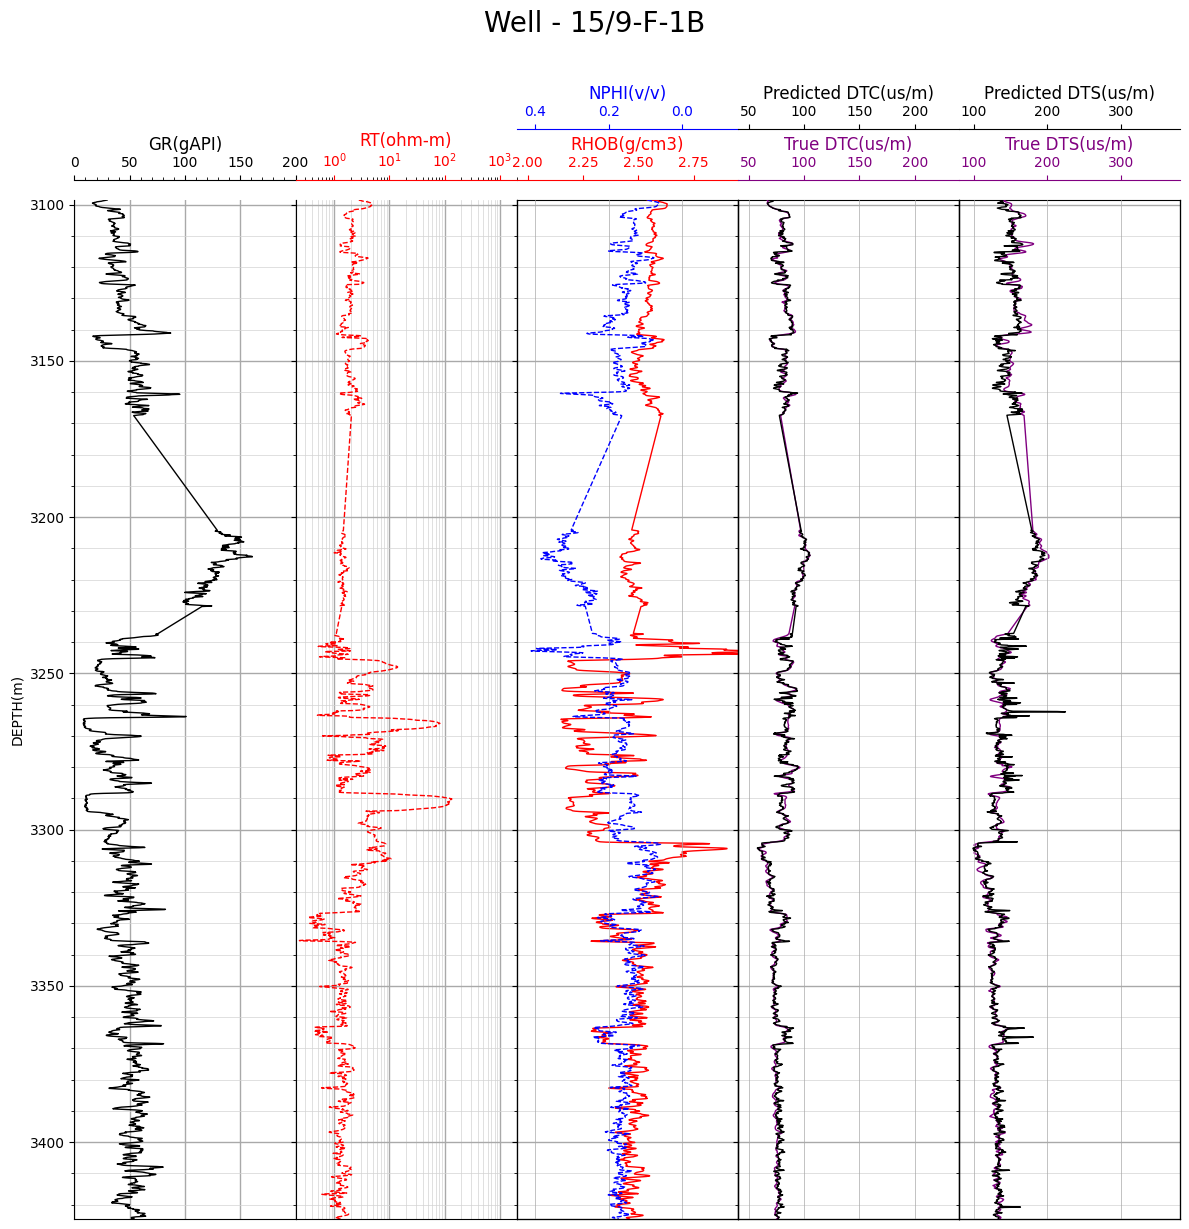

In [ ]:
#well4
well4_new = predict_logs(train_well4_x, train_well4_y, well4)
metrics(pred=well4_new['Predicted DTC'], gt=well4_new['DTC'], name='DTC')
metrics(pred=well4_new['Predicted DTS'], gt=well4_new['DTS'], name='DTS')

make_log_plot(well4_new, 'GR', 'RT', 'RHOB', 'NPHI', 'DTC',
              'Predicted DTC', 'DTS', 'Predicted DTS', '15/9-F-1B')